# Section 3 : Biais de confusion 


Durant la seconde sections on a discuter des DAG et du but de la inférence causale qui est de via après les interventions trouver $ P(Y|X) $ par la méthode: $ P(Y|do(X)) $ 

Si nous ne pouvons pas effectuer correctement une intervention du faites que nous n'avons que les *données observé* (on ne peux pas répliquer deux terre en meme temps)

Pour résoudre, ce cas-là il faut trouver des expression sans do donc transformer $ P(Y|do(X)) $ en une expression "do-free" donc sans do.



In [1]:
# TODO: => revoir Comprendre pouquoi on besoin de faire des interventions ? 

Pour résoudre ce type de problème, il existe des modèles 'graphique' de causalité. Il existe avec ce type de modèle des critère facilement applicable comme les portes arrières et les portes avants(ou la procedure do calculus).

L'idenification de ces critère ont été généralisé par des algorithmes que nous verrons par la suite. 

---

Le **biais de confusion** (ou **confounding bias**) est un problème qui survient en inférence causale lorsque l'on cherche à estimer la relation causale entre une variable $ X $ (cause supposée) et une variable $ Y $ (effet supposé), mais qu'une troisième variable $ Z $ influe à la fois sur $ X $ et $ Y $. Cela peut conduire à une mauvaise estimation de l'effet causal de $ X $ sur $ Y $, car la relation observée entre ces deux variables est en partie due à l'influence de $ Z $.

En termes de **graphe causal**, le biais de confusion apparaît lorsqu'un **chemin non causal** (appelé **chemin de backdoor**) relie $ X $ et $ Y $ à travers une variable $ Z $, ou plusieurs variables. 

### Définition formelle dans les graphes causaux

Dans un graphe causal dirigé (Directed Acyclic Graph, ou DAG) :
- Une variable $ Z $ est appelée **confondante** si elle agit comme une cause commune à $ X $ et $ Y $. Autrement dit, $ Z $ influence $ X $ et $ Z $ influence $ Y $, créant un chemin reliant $ X $ à $ Y $ qui n'est pas directement causal.
- Le **biais de confusion** se produit si on ne prend pas en compte $ Z $ dans l'estimation de la relation $ X \to Y $.

Un exemple classique est celui d'un graphe où :
- $ Z \to X $ (Z influence X)
- $ Z \to Y $ (Z influence Y)
- $ X \to Y $ (relation causale qu'on veut estimer)

Dans ce cas, la relation entre $ X $ et $ Y $ est biaisée par le chemin **indirect** qui passe par $ Z $.

### Illustration avec un exemple concret

Supposons que nous souhaitions estimer l'effet de l'exercice physique ($ X $) sur la perte de poids ($ Y $). Une variable confondante pourrait être l'alimentation ($ Z $) :
- Une personne qui mange sainement ($ Z $) est plus susceptible de faire de l'exercice ($ Z \to X $).
- Une alimentation saine influence aussi directement la perte de poids ($ Z \to Y $).

Si on ignore $ Z $ dans l'analyse, on pourrait attribuer à $ X $ (l'exercice) un effet plus important sur $ Y $ (la perte de poids) qu'il n'en a réellement, car l'alimentation ($ Z $) n'a pas été contrôlée.

### Solution au biais de confusion : le critère du chemin de backdoor

Le critère du chemin de backdoor permet d'identifier et de corriger le biais de confusion dans un graphe causal. Pour estimer l'effet causal de $ X $ sur $ Y $, il faut **bloquer** tous les chemins de backdoor reliant $ X $ à $ Y $. Cela peut être fait en contrôlant statistiquement pour les confondants ($ Z $) via :
- **Ajustement** (e.g., inclure $ Z $ comme covariable dans une régression),
- **Appariement** (e.g., matching basé sur $ Z $),
- **Stratification** (analyser $ X $ et $ Y $ dans des sous-groupes homogènes en $ Z $).

### Résumé

Le **biais de confusion** est un biais introduit par des variables qui créent une corrélation apparente entre $ X $ et $ Y $ sans que cette corrélation soit causale. En graphes causaux, il correspond à des chemins de backdoor reliant $ X $ à $ Y $. Identifier et bloquer ces chemins est essentiel pour estimer correctement les relations causales.

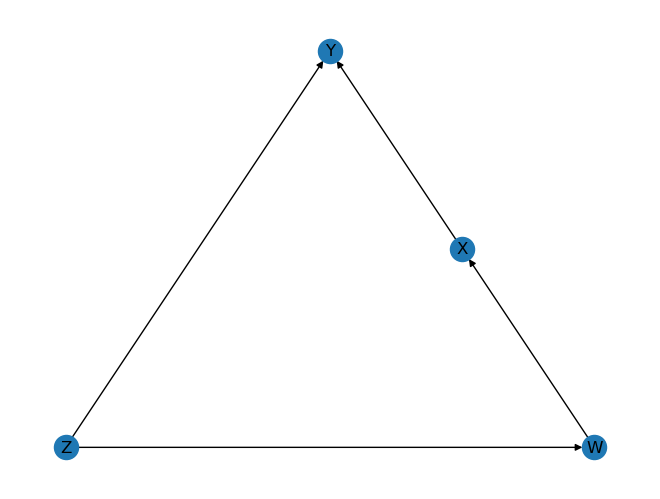

In [29]:
import networkx as nx

G = nx.DiGraph([
    ("Z", "W"),
    ("W", "X"),
    ("Z", "Y"),
    ("X", "Y"),
])
nx.draw_planar(G, with_labels=True)

Sur cette exemple, avec X en entré et Y en sortie, le chemin confondant est $ X \gets W \gets Z \to Y $

L'autre chemin de $ X \to Y $ est directe et donc causal.

Pour connaitre l'effet de X sur Y, nous devons bloqué ce chemin ($ X \gets W \gets Z \to Y $) pour eviter les effets parasites.

**Définition : d-séparation (Pearl et al., 2016, p. 46)**

Un chemin p est bloqué par un ensemble de nœuds Z si et seulement si
1. p contient une chaîne de nœuds A → B → C ou une fourche A ← B → C telle que le nœud central B est dans Z (c'est-à-dire que B est conditionné), ou
2. p contient un collisionneur A → B ← C tel que le nœud de collision B n'est pas dans Z et qu'aucun descendant de B n'est dans Z.

--- 

En graphe causal, **"bloquer un chemin"** signifie couper l'influence qu'un chemin exerce entre deux variables dans le graphe, de manière à empêcher toute corrélation ou dépendance induite par ce chemin. Cela permet de neutraliser les effets des chemins non causaux (comme les chemins de backdoor), qui pourraient biaiser l'estimation de l'effet causal direct.

Voici une explication détaillée de ce concept :

---

### **Chemins dans les graphes causaux**
Un **chemin** dans un graphe causal est une séquence de liens entre deux variables, qu'ils soient causaux (dirigés) ou non causaux (par exemple, un chemin de backdoor). 

- Un **chemin causal** est un chemin entièrement dirigé (par exemple $ X \to Y $).
- Un **chemin non causal** est un chemin contenant des variables intermédiaires ou des relations confondantes (par exemple $ X \gets Z \to Y $).

---

### **Bloquer un chemin**
Un chemin est dit "bloqué" lorsqu'il est rendu **non pertinent** pour transmettre une dépendance statistique entre deux variables. Cela se fait en conditionnant ou en contrôlant certaines variables dans le chemin.

Le blocage repose sur les propriétés de **d-séparation** (ou séparation directionnelle) dans un graphe causal.

#### **Règles pour bloquer un chemin** :
1. **Pour un chemin passant par une chaîne causale** $ A \to B \to C $ :
   - Conditionner sur $ B $ (c'est-à-dire inclure $ B $ dans votre analyse statistique) **bloque le chemin**.
   - Exemple : Si $ A \to B \to C $, alors conditionner sur $ B $ empêche la corrélation entre $ A $ et $ C $ d'être transmise via $ B $.

2. **Pour un chemin passant par une cause commune (confounding)** $ A \gets B \to C $ :
   - Conditionner sur $ B $ bloque le chemin.
   - Exemple : Si $ A \gets B \to C $, alors conditionner sur $ B $ élimine la corrélation induite entre $ A $ et $ C $ par $ B $.

3. **Pour un chemin passant par un colliseur** $ A \to B \gets C $ :
   - Conditionner sur $ B $ (ou une descendance de $ B $) **ouvre le chemin**, car cela crée une corrélation entre $ A $ et $ C $.
   - Exemple : Si $ A \to B \gets C $, alors ne pas conditionner sur $ B $ est nécessaire pour bloquer le chemin. Conditionner sur $ B $ introduirait une dépendance entre $ A $ et $ C $ même s'il n'y en a pas.

---

### **Exemple d'application**

#### Problème de backdoor
Supposons que nous souhaitons estimer l'effet causal de $ X $ sur $ Y $, mais un chemin de backdoor existe : $ X \gets Z \to Y $.

- $ Z $ est une cause commune de $ X $ et $ Y $, et il introduit une corrélation entre eux.
- Pour **bloquer** ce chemin, il faut **conditionner sur $ Z $** (par exemple, inclure $ Z $ comme covariable dans une analyse de régression).

#### Attention aux colliseurs
Si le graphe contient un colliseur $ X \to W \gets Y $ (par exemple, une variable qui est causée à la fois par $ X $ et $ Y $), conditionner sur $ W $ **ouvre un chemin** non causal entre $ X $ et $ Y $. Dans ce cas, pour estimer correctement l'effet causal de $ X $ sur $ Y $, il faut **ne pas conditionner** sur $ W $.

---

### **Résumé**
- "Bloquer un chemin" signifie rendre ce chemin **statistiquement non pertinent** en empêchant qu'il transmette une dépendance entre deux variables.
- Le blocage est effectué en conditionnant certaines variables selon les règles de d-séparation.
- Cela est essentiel pour isoler les chemins causaux et obtenir une estimation correcte des relations causales dans un graphe.

## Les Ajustements des portes arrières (Backdoor Adjustment)


Definition: **The backdoor criterion (Pearl et al., 20216, p.61)**

Soit des paires ordonnées de variables (X, Y) dans un DAG G, un ensemble de variable Z satisfait le critère de porte arrière par rapport à (X, Y) si:
- aucun noeud dans Z est un descendant de X, 
- Z bloque tous les chemin entre X et Y qui continnent une flèche vers X.  

Si l'ensemble de variables Z satifait le critère de backdoor par rapport à X et Y, l'effet causal est donnée de la façon suivante:
$$ 
 P(Y = y|do(X=x)) = \sum_z P(Y = y| X=x, Z=z)P(Z=z)
$$ 

Ici comment on le voit l'expression devitn "do-free" !

## Exercice trouver toutes les backdoor effect dans le graph suivant:

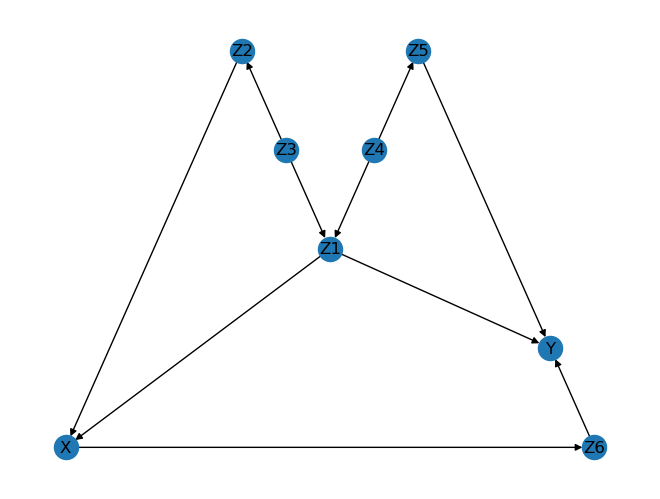

In [38]:
import networkx as nx

G = nx.DiGraph([
    ("X", "Z6"),
    ("Z6", "Y"),
    ("Z2", "X"),
    ("Z1", "Y"),
    ("Z5", "Y"),
    ("Z3", "Z2"),
    ("Z3", "Z1"),
    ("Z1", "X"),
    ("Z4", "Z1"),
    ("Z4", "Z5"),
])
nx.draw_planar(G, with_labels=True)

Voici l'ensemble **minimal** des Z possible pour valider le critère:
- {Z3, Z1}
- {Z2, Z1}
- {Z1, Z5}
- {Z2, Z4}

Pourquoi celle ci ?

A chaque fois on bloque Z1, car il bloque le chemin entre X et Y. Cependant le reste du chemin n'est pas complétement bloqué car il y a la suite ($ X \gets Z2 \gets Z3 \to Z1 \gets Z4 \to Z5 \to Y $) Ainsi pour bloquer ce chemin il faut au moins une variable à bloquer comme fait précédemment donc soit Z2, Z3, Z4, Z5.

SyntaxError: unterminated string literal (detected at line 1) (144706862.py, line 1)